This project utilizes the Ecuador Sales Datasets from the Kaggle Time Series competition. The goal is to explore the data and create a model to forecast future sales based on the given features or those that are engineered.

<h1>0. Import data and libraries</h1>

In [1]:
##### Data analysis and cleaning #####
import numpy as np
import pandas as pd

##### Visualization ######
import matplotlib.pyplot as plt
from matplotlib import cycler
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
# !pip install folium
import folium
# !pip install dash
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import geopandas as gpd # for geojson data when creating choropleth dashboard

##### Time Series #####
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

##### Regression #####
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

##### Other #####
from itertools import product
from math import floor
import datetime as dt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
oil = pd.read_csv('oil.csv')
holidays_events = pd.read_csv('holidays_events.csv')

datasets = [train, test, stores, transactions, oil, holidays_events]

<h1>1. Exploratory Data Analysis</h1>

First, a quick run through the descriptive statistics of each dataframe available. Some of the statistics will not be meaningful, such as the mean store number, but this is a quick and efficient way to gather those which are insightful.

In [3]:
for df in datasets:
    print(df.info(), '\n\n', df.describe())
    print('\n','='*45,'\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None 

                  id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02



<class 'pandas.core.frame.DataFrame'>
RangeInde

In [4]:
def get_year_month(df):
    """
    Create year and month columns using date column. This occurs in place.
    """
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
def get_dofw(df):
    """
    Create a day of week column. This occurs in place
    """
    df['date']=pd.to_datetime(df['date']) # to datetime object
    df['dofw'] = df['date'].apply(lambda x: x.day_name()) # get day of week

The most basic and foundational visualization to begin with is the total sales per day. Alongside this total will be the weekly moving average.

<b>Methods of Smoothing:</b>
* <i>Moving Average</i>
* <i>Weighted Average</i>: MA with larger weight assigned to more recent data and weights summing up to 1
* <i>Exponential Smoothing</i>: All previous data holds weight, but at an exponentially decaying rate
* <i>Double Exponential Smoothing</i>: Exponential smoothing individually performed on both intercept/level and slope/trend for $\hat{y}_{t}=L_{t-1}+T_{t-1}$
* <i>Triple Exponential Smoothing / Holt-Winters</i>: Seasonality smoothing added to double exponential smoothing

In [5]:
# Create df with daily unit sales
df_daily = train.loc[:,['date', 'sales', 'onpromotion']]
df_daily = df_daily.groupby('date').sum()
# Date is the index, which cannot be passed for the x-axis, so df index must be reset
df_daily.reset_index(inplace=True)

# Compute a 7 day moving/rolling average
df_daily[ 'week_moving_avg' ] = df_daily.sales.rolling(7).mean()

trace0 = go.Scatter(
    x=df_daily.date,
    y=df_daily.sales,
    mode='lines',
    name='Daily Unit Sales',
    marker_color='#537A5A')

trace1 = go.Scatter(
    x=df_daily.date,
    y=df_daily.week_moving_avg,
    mode='lines',
    name='Weekly Moving Average',
    marker_color='#93c47d')

layout = go.Layout(
    title='Unit Sales by Date',
    title_x=0.3,
    template='plotly_white',
    hovermode='x unified')

go.Figure(data=[trace0,trace1], layout=layout)
# An alternative method is passing multiple variables for y in plotly express 

In [6]:
df_month = df_daily.loc[:,['date','sales', 'onpromotion']]
get_year_month(df_month)
df_month = df_month.groupby(['year','month']).mean()
# Month is the index, which cannot be passed a column for the graph, so df index must be reset
df_month.reset_index(inplace=True)

In [124]:
month_name =['Jan', 'Feb', 'Mar', 'April', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

cmap =['#637939', '#8CA251', '#B4CF6B', '#CEDB9C', '#8C6D31', '#BD9E39',
    '#E7BA52', '#E7CB94', '#843C39','#AD494A', '#D6616B', '#E7969C']

# plotly express does not support arbitrary subplots, 
# so instead they must be created with the lower-level graph_objs.

# Initialize Subplots
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'scatter'}, {'type':'bar'}]],
    column_widths=[0.43,0.57])

# Layout
fig.update_layout(
    title='Sales by Month',
    title_x=0.46,
    template='plotly_white',
    hovermode='x unified',
    barmode='stack',
    showlegend=False)

# Subplot 1
color = 0 # Variable to cycle through custom colors for each year
for year, sales in df_month.groupby('year'):
    fig.add_trace(
        go.Scatter(
            x=sales.month,
            y=sales.sales,
            name=year,
            mode='lines',
            line_color = px.colors.qualitative.Antique[color]),
        row=1,
        col=1)
    color += 1

fig.update_xaxes(
    row=1, col=1,
    title_text='Month',
    tickvals=[1,2,3,4,5,6,7,8,9,10,11,12],
    ticktext=month_name)
fig.update_yaxes(row=1, col=1, title_text='Units Sold')

# Subplot 2: Stacked Bar 
count=0
for month in month_name:
    fig.add_trace(
        go.Bar(
            name=month_name[count],
            x=df_month['year'].unique(),
            y=df_month.loc[df_month['month']==(count+1),'sales'],
            marker_color=cmap[count]),
        row=1, col=2)
    count+=1

fig.show()

While the year-to-year trend is clearly increasing, the month-to-month trend does not appear to be particularly consistent. Each month has seen an increase or decrease in sales to varying degrees, except for December. Given this variability, a <i>month</i> feature would not be reliable in a forecasting model. Instead, a boolean feature <i>is_december</i> will be used because the increase in sales during december has been unanimous throughout the data.

In [8]:
fig = px.scatter(
    df_daily, x='date', y='sales',
    color='onpromotion',
    color_continuous_scale='earth',
    title='Total Unit Sales and Items on Promotion')
fig.update_layout(
    {'xaxis': {'title':'Date'},
    'yaxis': {'title':'Average Units Sold'}},
    template='plotly_white',
    title_x=0.475)

fig.show()

In [8]:
df_dofw = df_daily.loc[:, ['date', 'sales']]
get_year_month(df_dofw) # get year
get_dofw(df_dofw) # get day of week
df_dofw = df_dofw.groupby(['dofw','year']).sum().reset_index()

fig = go.Figure(
    go.Bar(
        x=df_dofw['year'],
        y=df_dofw['sales'].loc[df_dofw['dofw']=='Monday'],
        name='Monday',
        marker_color=['#17869E']*5))
for day in ['Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    if day in ['Saturday','Sunday']:
        color = '#51C4D3'
    else: 
        color = '#17869E'
    fig.add_trace(
        go.Bar(
            x=df_dofw['year'],
            y=df_dofw['sales'].loc[df_dofw['dofw']==day],
            name=day,
            marker_color=[color]*5))
fig.update_layout(
    title='Total Sales by Day of Week',
    title_x=0.3,
    title_y=0.85,
    width=750,
    height=400,
    template='plotly_white')
fig.show()

Note that 2017 has lower total sales because the data does not extend to the end of the year. Weekdays vs weekends certainly display the greatest difference in sales, but the comparison of each individual day is quite consistent throughout the years. For this reason, the actual <i>day_of_week</i> feature will be included when forecasting instead of simplifying this to a boolean <i>is_weekend</i>.

/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_59748/3418722279.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



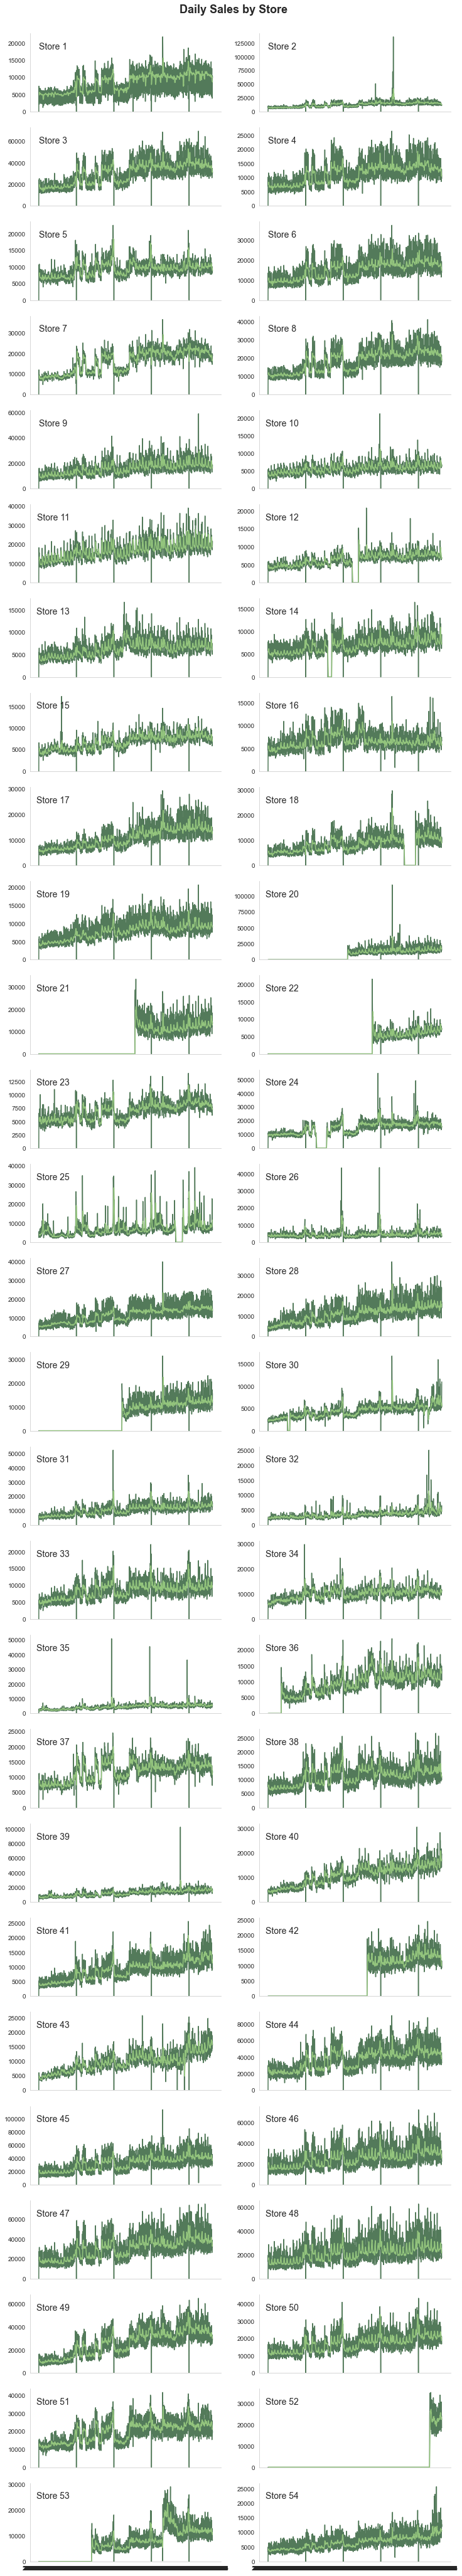

In [9]:
# Create df of daily sales by each store
df_daily_store = train.copy()
df_daily_store = df_daily_store.loc[:,['date', 'sales', 'store_nbr']].groupby(['date','store_nbr']).sum()
# Date is the index, which cannot be passed for the x-axis, so df index must be reset
df_daily_store.reset_index(inplace=True)
# Create moving average column based on each store's sales
df_daily_store['week_moving_avg'] = None
for store in df_daily_store.store_nbr.unique():
    df = df_daily_store.loc[df_daily_store['store_nbr']==store,:]
    df_daily_store['week_moving_avg'].loc[df_daily_store['store_nbr']==store] = df.sales.rolling(7).mean()

# Create Figure and subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(27, 2, figsize=(12,64), sharex=True) # 54 stores in total
sns.despine(fig)
fig.suptitle('Daily Sales by Store', fontsize=18, fontweight=600, y=1.01)
fig.subplots_adjust(top=1)

# Plots
plot=0
for store in df_daily_store.store_nbr.unique():
    ax=axs[floor(plot/2), plot%2]
    sns.lineplot(
        data=df_daily_store.loc[df_daily_store['store_nbr']==store],         
        x='date',
        y='sales',
        color='#537A5A',
        ax=ax)
    sns.lineplot(
        data=df_daily_store.loc[df_daily_store['store_nbr']==store],
        x='date',
        y='week_moving_avg',
        color='#93c47d',
        ax=ax)
    ax.set(
        ylabel=None,
        xlabel=None,
        ylim=(0,None))
    ax.set_title(
        f'Store {store}',
        y=0.75,
        x=0.12,
        fontdict={'size':14,'weight':500})
    ax.grid(False)
    plot+=1

Several stores have no sales for an extended period of time--these stores likely had not started business yet or the data is not available. These stores and dates will be considered when forecasting and will be placed in the <i>stores_closed</i> dataframe. A more explicit view of store closures can be explored below:

In [10]:
# Gather data for when a particular store had no sales
stores_closed = train.groupby(['store_nbr','date']).sum()
stores_closed = stores_closed.loc[stores_closed['sales']==0]
stores_closed.reset_index(inplace=True)

# Quick visualization of closed stores
fig = px.scatter(
    data_frame=stores_closed,
    x='date',
    y='store_nbr',
    title = 'Closed Stores',
    symbol_sequence =['square'],
    color_discrete_sequence=['#17869E',]*54)
fig.update_layout(
    {'yaxis':{'title':'Store Number'},
    'xaxis': {'title': ''}},
    title_x=0.475,
    title_y=0.85,
    template='plotly_white',
    height=500,
    width=780)
fig.update_traces(marker={'size': 4.5})

On the topic of zero sales, it is also worth checking if all stores sell all product families. If any store always has zero sales for a particular product family, then it is appropriate to forecast those zero sales will continue. These product families will be placed in the <i>zero_sales</i> dataframe.

In [11]:
zero_sales = train.loc[:,['store_nbr','family','sales']].groupby(['store_nbr','family']).sum()
zero_sales = zero_sales.loc[zero_sales['sales']==0]
zero_sales.columns=['lifetime_sales']

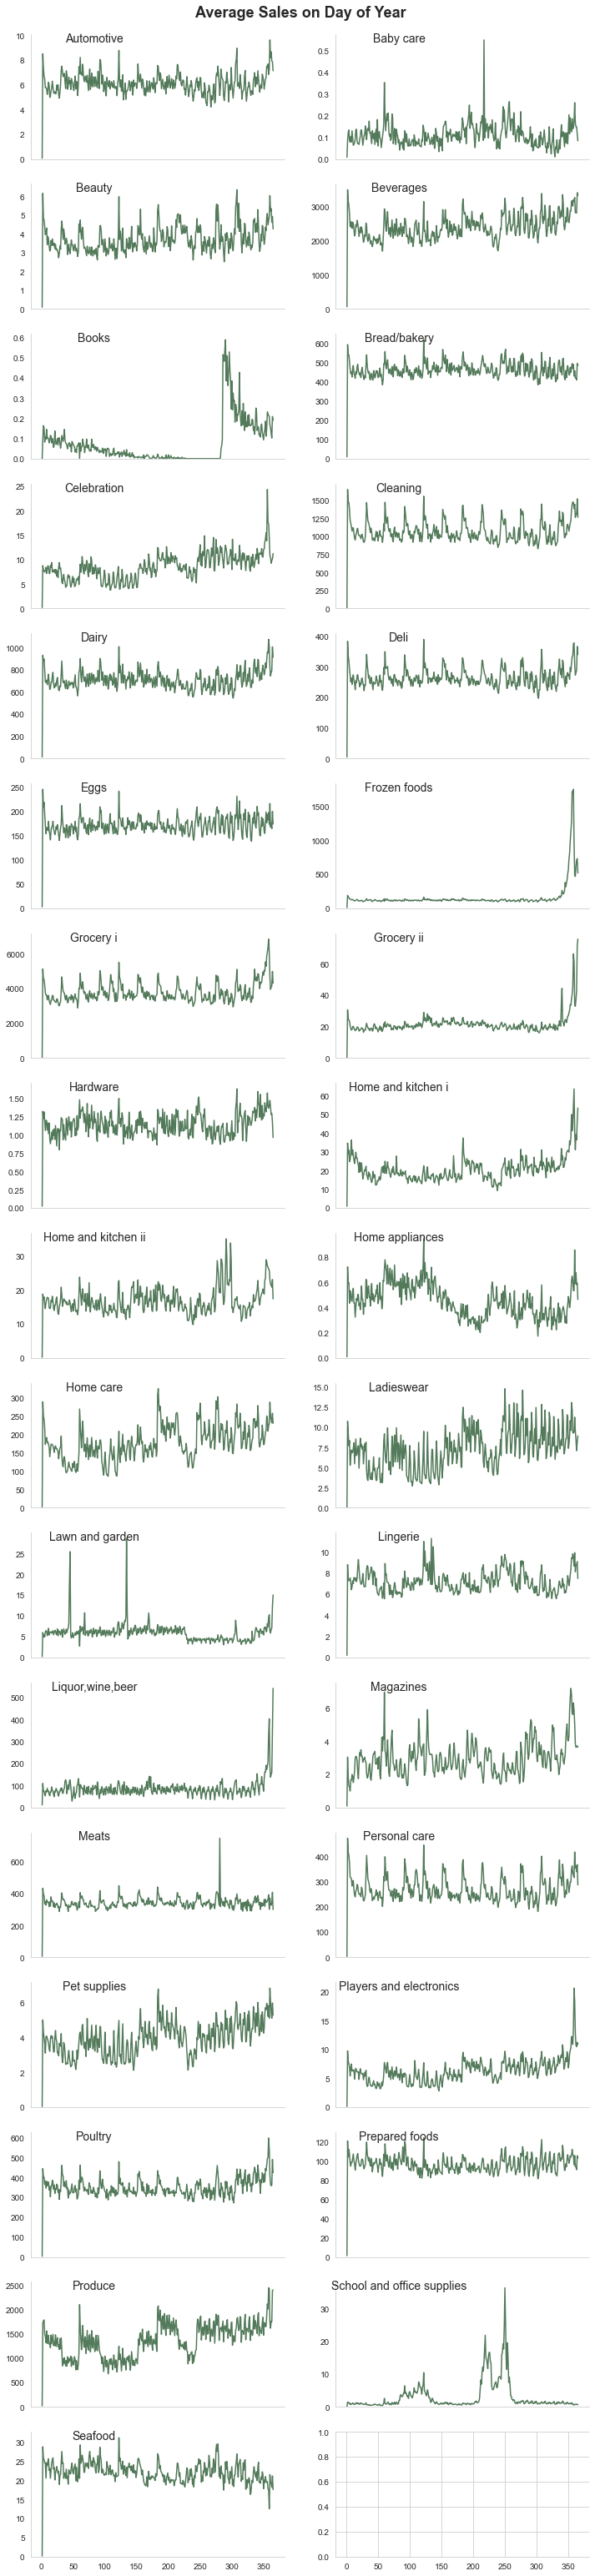

In [12]:
df_family = train.loc[:,['date','family','sales']].copy()
df_family['date'] = pd.to_datetime(df_family['date'])
df_family = df_family.groupby(['family',(df_family.date.dt.month),(df_family.date.dt.day)]).mean()

# Create Figure and subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(17, 2, figsize=(12,48), sharex=True) # 33 families in total
sns.despine(fig)
fig.suptitle('Average Sales on Day of Year', fontsize=18, fontweight=600, y=1.01)
fig.subplots_adjust(top=1)

# Plots
plot=0
for family in train.family.unique():
    ax=axs[floor(plot/2), plot%2]
    sns.lineplot(
        data=df_family.loc[family],         
        x=range(1,366),
        y=df_family.loc[family]['sales'],
        color='#537A5A',
        ax=ax)
    ax.set(
        ylabel=None,
        xlabel=None,
        ylim=(0,None))
    ax.set_title(
        family.capitalize(),
        y=0.9,
        x=0.25,
        fontdict={'size':14,'weight':500})
    ax.grid(False)
    plot+=1

Most spikes in sales by product occur in December due to the holidays. The feature <i>is_december</i>, previously mentioned, will help forecast these spikes. Books and office supplies, however, have HUGE spikes before the school year begins. This may need to be addressed while forecasting as well, perhaps with a random forest regression for

### <b>Project in Progress:</b>
<b>Much more is soon to be added. Upcoming work includes Autocorrelation, Partial Autocorrelation, Time Series Decomposition, Stationarity, SARIMA forecasting model, Linear Regression Model, Regularization methods such as Lasso and Ridge regression, and more!<b>

<h2>References and Resources</h2>

* <a href="https://otexts.com/fpp2/"><i>Forecasting Principles and Practice</i> Textbook</a>
* <a href="https://people.duke.edu/~rnau/411home.htm">Duke University's <i>Statistical Forecasting: notes on regression and time series analysis</i></a><br>
* <a href="https://www.youtube.com/playlist?list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s">Aric LaBarr's Video Series</a>
<br>
* <a href="https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python">mlcourse.ai Kaggle Notebook</a>
* <a href="https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting/notebook">Acea Smart Water Analytics Kaggle Notebook</a>
